In [1]:
!pip install -U scikit-learn

  Using cached scikit_learn-1.0.1-cp37-cp37m-macosx_10_13_x86_64.whl (7.9 MB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
  Using cached scipy-1.7.2-cp37-cp37m-macosx_10_9_x86_64.whl (33.0 MB)
  Using cached threadpoolctl-3.0.0-py3-none-any.whl (14 kB)


In [ ]:
!pip install pandas

In [4]:
!pip install tensorflow

     |████████████████████████████████| 276 kB 1.2 MB/s            
  Using cached six-1.16.0-py2.py3-none-any.whl (11 kB)
  Using cached PyYAML-6.0-cp37-cp37m-macosx_10_9_x86_64.whl (189 kB)
  Using cached numpy-1.21.4-cp37-cp37m-macosx_10_9_x86_64.whl (16.9 MB)
  Using cached scipy-1.7.2-cp37-cp37m-macosx_10_9_x86_64.whl (33.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4
  Attempting uninstall: six
    Found existing installation: six 1.16.0
    Uninstalling six-1.16.0:
      Successfully uninstalled six-1.16.0
  Attempting uninstall: keras
    Found existing installation: keras 2.7.0
    Uninstalling keras-2.7.0:
      Successfully uninstalled keras-2.7.0


In [1]:
!pip install nltk

In [16]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics, regularizers
from keras.preprocessing import sequence
import pandas as pd
import keras
import pickle
import string
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aromanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aromanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
wordnet_lemmatizer = WordNetLemmatizer()

In [18]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in string.punctuation])
    return punctuationfree


def lemmatizer(text):
    if len(text.split(' ')) == 1:
        text = [text]
    else:
        text = text.split(' ')
    lemm_text = " ".join([wordnet_lemmatizer.lemmatize(word) for word in text])
    return lemm_text


def remove_stopwords(text):
    if len(text.split(' ')) == 1:
        text = [text]
    else:
        text = text.split(' ')

    output = [i for i in text if i not in stopwords.words('english')]
    output = " ".join(output)

    return output


def preprocess_str(text):
    text = text.strip()
    text = text.lower()
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatizer(text)
    return text

In [19]:
jobs_dataset = pd.read_csv('../data/JobsDataset.csv')[['Job Title', 'Query']]
jobs_dataset['Job Title'] = jobs_dataset['Job Title'].apply(lambda x: preprocess_str(x))
jobs_dataset = jobs_dataset.dropna().drop_duplicates()

In [20]:
jobs_dataset['Job Title']

0                    junior data scientist apprenticeship
1                      hbo data scientist content science
2                                   junior data scientist
3                                       jr data scientist
4                          data scientist premium content
                              ...                        
9970                            lead enterprise architect
9972                        lead infrastructure architect
9973                              microservices developer
9979                             virtualization architect
9998    software development engineer full stack – ent...
Name: Job Title, Length: 7248, dtype: object

In [22]:
vocab = set([])

for title in jobs_dataset['Job Title']:
    words = title.split(' ')
    for word in words:
        vocab.add(word)

In [25]:
#Split the dataset to Training and Test subsets (90/10)
train, test = train_test_split(jobs_dataset, test_size = 0.1, random_state = 17) #random_state = None

train_titles = train['Job Title']
train_labels = train['Query']
 
test_titles = test['Job Title']
test_labels = test['Query']

In [37]:
# Model Parameters
vocab_size = len(vocab)

sequences_length = 32

embedding_dimensionality = 100 #possibly low??
max_features = vocab_size #equal to vocab_size

num_labels = len(train_labels.unique())
batch_size = 32
nb_epoch = 20

nof_filters = 200
kernel_size = 16

hidden_dims = 512

In [38]:
# Convert Texts to Numeric Vectors for Input
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_titles)

x_train = tokenizer.texts_to_sequences(train_titles)
x_test = tokenizer.texts_to_sequences(test_titles)

x_train = sequence.pad_sequences(x_train, maxlen = sequences_length, padding = 'post')
x_test = sequence.pad_sequences(x_test, maxlen = sequences_length, padding = 'post')

encoder = LabelBinarizer()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

In [39]:
model = Sequential()
model.add(Embedding(max_features, embedding_dimensionality, input_length = sequences_length))

model.add(Conv1D(nof_filters, kernel_size, padding='valid', activation='relu', strides = 1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', #'sgd', 'adam', 'RMSprop', 'Adagrad'
                   metrics = [metrics.categorical_accuracy])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 100)           345700    
                                                                 
 conv1d_3 (Conv1D)           (None, 17, 200)           320200    
                                                                 
 global_max_pooling1d_3 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 512)               102912    
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                      

In [40]:
checkpoint_filepath = './checkpoints'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_categorical_accuracy',
    verbose=True,
    mode='max',
    save_best_only=True
)

In [41]:
history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = nb_epoch,
    verbose = True,
    validation_split = 0.2,
    callbacks=[model_checkpoint_callback]
)

Epoch 1/20
162/164 [============================>.] - ETA: 0s - loss: 2.7043 - categorical_accuracy: 0.1977
Epoch 00001: val_categorical_accuracy improved from -inf to 0.47663, saving model to ./checkpoints
164/164 [==============================] - 8s 41ms/step - loss: 2.6970 - categorical_accuracy: 0.1999 - val_loss: 1.7475 - val_categorical_accuracy: 0.4766
Epoch 2/20
163/164 [============================>.] - ETA: 0s - loss: 1.5423 - categorical_accuracy: 0.5309
Epoch 00002: val_categorical_accuracy improved from 0.47663 to 0.56322, saving model to ./checkpoints
164/164 [==============================] - 7s 43ms/step - loss: 1.5426 - categorical_accuracy: 0.5307 - val_loss: 1.4580 - val_categorical_accuracy: 0.5632
Epoch 3/20
163/164 [============================>.] - ETA: 0s - loss: 1.2109 - categorical_accuracy: 0.6344
Epoch 00003: val_categorical_accuracy improved from 0.56322 to 0.60000, saving model to ./checkpoints
164/164 [==============================] - 8s 48ms/step - los

In [44]:
model.load_weights(checkpoint_filepath)

In [45]:
score = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = True)
 
print('\nTest categorical_crossentropy:', score[0])
print('Categorical accuracy:', score[1])


23/23 [==============================] - 0s 6ms/step - loss: 1.3600 - categorical_accuracy: 0.5848

Test categorical_crossentropy: 1.359977126121521
Categorical accuracy: 0.5848276019096375


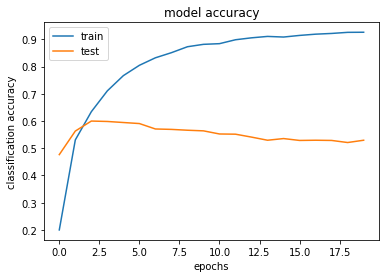

In [46]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('classification accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [29]:
model.save('../classifier-microservice/model.h5')

In [32]:
with open('../classifier-microservice/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [47]:
with open('../classifier-microservice/encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)